In [1]:
import io
import requests
from PIL import Image
from secret import STATIC_API_KEY, GEOKODER_KEY

## Static API

In [2]:
request = requests.get(url='https://static-maps.yandex.ru/v1', params={
    'apikey': STATIC_API_KEY, 
    # 'll': '37.366922,55.844520', 
    # 'z': 14, 
    'pt': '37.361629,55.849641,pm2rdl1~37.618878,55.751427,pm2wtm'
})
# 37.369374,55.844975

request.status_code, request.url, request.content

(200,
 'https://static-maps.yandex.ru/v1?apikey=ab7b77a0-0735-47c0-b613-1d913ca62d14&pt=37.361629%2C55.849641%2Cpm2rdl1~37.618878%2C55.751427%2Cpm2wtm',
 b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x01\xc2\x08\x03\x00\x00\x00\x04\xadGV\x00\x00\x02aPLTE\xe8\xf5\xd7\xe5\xf5\xd5\xfa\xf7\xf0\xfa\xf8\xef\xfb\xf9\xf3\xf5\xf3\xed\xf9\xf6\xed\xf4\xf1\xea\xb8\xdf\xf5\xff\xf5\xb5\xf7\xf5\xeb\xd3\xeb\xbd\xe4\xf3\xd3\xd8\xf1\xc1\xff\xce{\xff\xfe\xf7\xfb\xfa\xf5\xde\xf2\xc8\xd8\xf1\xc2\xe4\xf4\xd4\xdf\xef\xd0\xd5\xec\xbc\xfd\xfc\xf2\xe7\xf4\xd6\xfc\xfa\xf4\xff\xe2\x94\xff\xff\xff\xf9\xf7\xee\xde\xed\xcf\xf3\xf1\xeb\xf7\xf6\xec\xe7\xf4\xd7\xfa\xf9\xf3\xfa\xf8\xf2\xdb\xf2\xc6\xd9\xec\xc9\xed\xeb\xe7\xfe\xe1\x96\xe9\xe8\xe7\xf9\xf8\xf1\xde\xed\xce\xfa\xfa\xf4\xfa\xf9\xf4\xe7\xf3\xd6\xd4\xf1\xbd\xfd\xe7\xa7\xdb\xf1\xc6\xd8\xf2\xc2\xff\xe1\x94\xf2\xef\xe8\xfe\xda\x8c\xfc\xdd\xa5\xda\xf1\xc4\xfe\xcdz3w\xe4\xdc\xf3\xc9\xe1\xf3\xce\xd7\xed\xc4\xff\xe1\x95\xec\xeb\xe9888\xda\xf2\xc4\xda\xf2\x

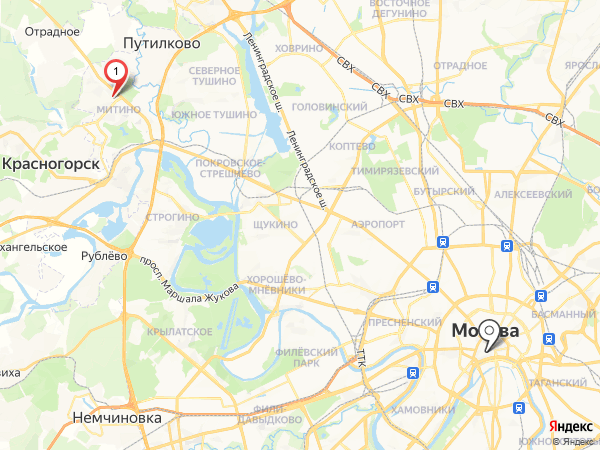

In [3]:
image = Image.open(io.BytesIO(request.content))
image

## Geocoder API

In [4]:
request = requests.get('https://geocode-maps.yandex.ru/1.x', params={
    'apikey': GEOKODER_KEY, 
    'geocode': 'парк москва', 
    'format': 'json', 
    'lang': 'ru_RU'
})

# https://geocode-maps.yandex.ru/1.x?apikey=a31ab51a-6934-47a0-8de7-357ffd6b4b29&geocode=митино&format=json&lang=ru_RU
request.status_code

200

In [5]:
data = request.json()
data

{'response': {'GeoObjectCollection': {'metaDataProperty': {'GeocoderResponseMetaData': {'request': 'парк москва',
     'results': '10',
     'found': '2'}},
   'featureMember': [{'GeoObject': {'metaDataProperty': {'GeocoderMetaData': {'precision': 'other',
        'text': 'Россия, Рязань, сквер 60-летия Победы',
        'kind': 'vegetation',
        'Address': {'country_code': 'RU',
         'formatted': 'Россия, Рязань, сквер 60-летия Победы',
         'Components': [{'kind': 'country', 'name': 'Россия'},
          {'kind': 'province', 'name': 'Центральный федеральный округ'},
          {'kind': 'province', 'name': 'Рязанская область'},
          {'kind': 'area', 'name': 'городской округ Рязань'},
          {'kind': 'locality', 'name': 'Рязань'},
          {'kind': 'vegetation', 'name': 'сквер 60-летия Победы'}]},
        'AddressDetails': {'Country': {'AddressLine': 'Россия, Рязань, сквер 60-летия Победы',
          'CountryNameCode': 'RU',
          'CountryName': 'Россия',
        

## Example

In [6]:
def get_info_from_request(request: str) -> list[dict[str:str]]:
    request = requests.get(
        "https://geocode-maps.yandex.ru/1.x",
        params={
            "apikey": GEOKODER_KEY,
            "geocode": request,
            "format": "json",
            "lang": "ru_RU",
        },
    )
    
    data = request.json()
    
    res = []
    for obj in data['response']['GeoObjectCollection']['featureMember']:
        obj = obj['GeoObject']
        res.append({
            'name': obj['name'], 
            'coord': obj['Point']['pos'].replace(' ', ',')
        })
        
    return res
        
get_info_from_request('парк москва')

[{'name': 'сквер 60-летия Победы', 'coord': '39.658976,54.644702'},
 {'name': 'станция Перово, парк Перово-4', 'coord': '37.725469,55.763371'}]

In [7]:
def return_image(request: str) -> bytes:
    addresses = get_info_from_request(request)
    print(addresses)
    request = requests.get(
        url="https://static-maps.yandex.ru/v1",
        params={
            "apikey": STATIC_API_KEY,
            "pt": "~".join(
                [
                    f'{address["coord"]},pm2rdm{index}'
                    for index, address in enumerate(addresses, 1)
                ]       
            ),
            # 'z': 13
        },
    )
    
    if request.status_code == 200: 
        return request.content
    
    print(request.status_code)
    return b''

[{'name': 'сквер 60-летия Победы', 'coord': '39.658976,54.644702'}, {'name': 'станция Перово, парк Перово-4', 'coord': '37.725469,55.763371'}]


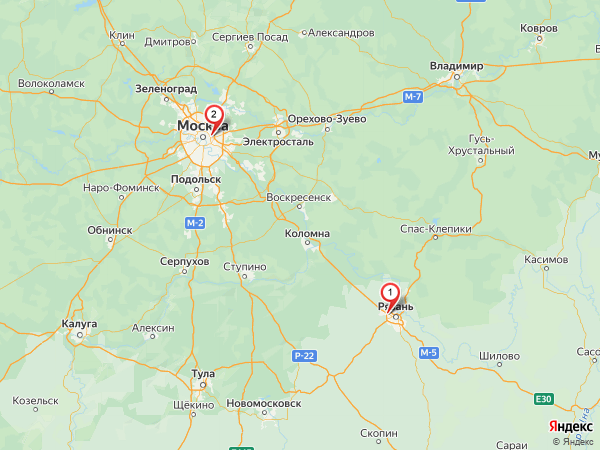

In [8]:
image = Image.open(io.BytesIO(return_image('москва парк')))
image